# 微调

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [3]:
# DATA_HUB是一个字典
# DATA_HUB = dict()
# DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

BadZipFile: File is not a zip file

In [6]:
data_dir = '..\data\hotdog'
# 以列表形式#返回从所有文件夹中得到的图片的路径以及其类别
# 如：[('./data/train\\cat\\1.jpg', 0)]
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

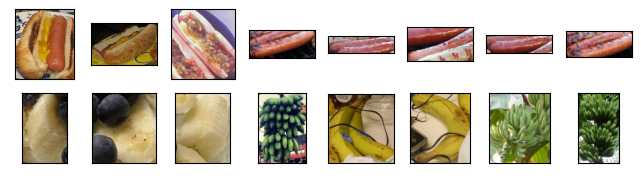

In [7]:
# 第i行的第0个表示图片路径，第1个表示所属类别
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs,2,8,scale=1);

在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为$224 \times 224$输入图像。
在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央$224 \times 224$区域作为输入。
此外，对于RGB（红、绿和蓝）颜色通道，我们分别*标准化*每个通道。
具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。

In [8]:
# 数据增广
# 对每个通道的均值和方差做normalization
normalize = torchvision.transforms.Normalize([0.485,0.456,0.406],
                                             [0.229,0.224,0.225])
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),normalize])

In [9]:
# pretrained = True：说明不仅把模型拿出来，还要把它训练好的参数拿出来
pretrained_net = torchvision.models.resnet18(pretrained = True)
# 打印出最后一层
pretrained_net.fc

C:\Users\Mine\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mine\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Mine/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Linear(in_features=512, out_features=1000, bias=True)

In [11]:
finetune_net = torchvision.models.resnet18(pretrained=True)
# 将预训练好的模型的最后一层全连接层随机初始化
# 因为只有是热狗、不是热狗两个类别
finetune_net.fc = nn.Linear(finetune_net.fc.in_features,2)
# 只对最后一层的权重做随机初始化
nn.init.xavier_uniform_(finetune_net.fc.weight)

C:\Users\Mine\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mine\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0192,  0.0524,  0.0723,  ..., -0.0063,  0.0546,  0.1028],
        [-0.0748,  0.0753,  0.0902,  ...,  0.0927,  0.0621, -0.0722]],
       requires_grad=True)

In [12]:
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,param_group=True):
    '''

    :param net:
    :param learning_rate:
    :param batch_size:
    :param num_epochs:
    :param param_group: 是否微调
    :return:
    '''
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                             transform=train_augs),batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                            transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    # 最后一层使用10倍学习率，其他层因为参数已经调好了只需要微调，学习率小
    if param_group:
        params_1x = [param
                     for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 2.00 GiB total capacity; 1.55 GiB already allocated; 0 bytes free; 1.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

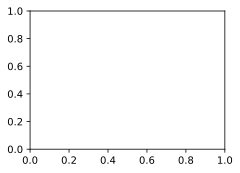

In [13]:
train_fine_tuning(finetune_net,5e-5)

In [ ]:
# 不使用微调，全部随机初始化
# 不设置pretrained参数
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features,2)
train_fine_tuning(scratch_net,5e-5,param_group=False)